### Plot types of residues' spatial information
### Active vs Nonactive

##### ↓ Extract spatial information

In [121]:
from Bio.PDB import *
import urllib.request
import numpy as np
import pandas as pd
from math import sqrt
import time
import matplotlib.pyplot as plt

In [4]:
cd C:\Users\Administrator\Desktop\temp

C:\Users\Administrator\Desktop\temp


In [10]:
backbone = ["N","CA","C","O"]
aminoAcidCodes = ["ALA","ARG","ASN","ASP","CYS","GLN","GLY","GLU","HIS","ILE","LEU","LYS",
                 "MET","PHE","PRO","SER","THR","TRP","TYR","VAL"]

In [127]:
peptidasesList = pd.read_csv("Y:/Yuan/temp/MCSA_EC3.4_peptidases.csv")
peptidasesList = peptidasesList[peptidasesList.iloc[:,4] == "residue"]
peptidasesList = peptidasesList.reset_index(drop=True)
bindingSiteDic = {}
for i in range(len(peptidasesList)):
    #print(bindingSiteDic)
    if peptidasesList.loc[i,"PDB"] not in bindingSiteDic:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    elif peptidasesList.loc[i,"chain/kegg compound"] not in bindingSiteDic[peptidasesList.loc[i,"PDB"]]:
         bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    else:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]][peptidasesList.loc[i,"chain/kegg compound"]].append(peptidasesList.loc[i,"resid/chebi id"])
for protein in bindingSiteDic:
    for chain in bindingSiteDic[protein]:
        bindingSiteDic[protein][chain] = list(set(bindingSiteDic[protein][chain])) 

##### ↓This example is protein 1pq5 chain A; active sites include

In [134]:
bindingSiteDic["1pq5"]["A"]

[192.0, 193.0, 194.0, 99.0, 195.0, 56.0]

In [129]:
pdbID = "1pq5"
chainOrder = "A"
PDB = PDBList()
PDB.retrieve_pdb_file(pdb_code = pdbID, pdir = "Y:/Yuan/temp", file_format="pdb")

'Y:/Yuan/temp\\pdb1pq5.ent'

In [130]:
p = PDBParser()
structure = p.get_structure("X","Y:/Yuan/temp/pdb"+pdbID+".ent")

In [131]:
oneChain = pd.DataFrame(columns = ["Seq","Residue","Center","Direction"])
if structure.header["resolution"]<=3.0:
    if chainOrder in [x.id for x in list(structure[0].get_chains())]: #Chain information not in pdb file
        for residue in structure[0][chainOrder]: 
            if residue.get_resname() in aminoAcidCodes: # Only treat common amino acid
                if len(list(residue.get_atoms())) >3:
                    if residue.get_resname() != "GLY":  # Glysine as a special case
                        point = vectors.Vector([0,0,0])
                        for atom in residue:
                            if(atom.get_name() not in backbone):
                                point = point + atom.get_vector()
                        center = point.__div__(len(residue)-4)
                        cToRGroup = residue["CA"].get_vector()-center
                        oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]        
                    else:
                        center = residue["CA"].get_vector()
                        cToRGroup = center - (residue["C"].get_vector()+residue["N"].get_vector()+residue["O"].get_vector()).__div__(3)
                        oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]

In [132]:
distanceMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
angleMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
numResidue = len(oneChain)
for row in range(0,numResidue):
    if row % 50 ==0:
        print(str(row)+"th row")
    for column in range(0,numResidue):
        coordinatesSubstraction = list(oneChain.loc[row,"Center"] - oneChain.loc[column,"Center"])
        distanceMatrix.iloc[row,column] = sqrt(sum(list(map(lambda x:x*x, coordinatesSubstraction))))
        v1 = oneChain.loc[row,"Direction"] 
        v2 = oneChain.loc[column,"Direction"]
        angleMatrix.iloc[row,column] = 180*np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))/np.pi

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


50th row
100th row
150th row
200th row


In [139]:
allSerAndHisAndAsp = oneChain[(oneChain["Residue"] == "SER")|(oneChain["Residue"] == "HIS")|(oneChain["Residue"] == "ASP")]

In [140]:
allSerAndHisAndAsp.is_copy = False
allSerAndHisAndAsp.loc[:,"active"] = np.where(allSerAndHis["Seq"].isin(bindingSiteDic["1pq5"]["A"]),"yes","no")

In [141]:
allSerAndHisAndAsp

,Seq,Residue,Center,Direction,active
5,21,SER,"<Vector -11.17, 14.18, -3.54>","<Vector 0.68, -1.19, -0.02>",no
7,23,SER,"<Vector -15.10, 10.94, 0.85>","<Vector 1.12, 0.34, 0.67>",no
10,26,ASP,"<Vector -13.43, 7.05, 1.83>","<Vector 0.08, -0.94, 1.34>",no
16,32,SER,"<Vector 0.30, 9.67, 5.85>","<Vector 0.22, -1.25, -0.17>",no
18,34,SER,"<Vector 5.62, 11.60, 6.77>","<Vector 0.74, -0.92, -0.70>",no
28,44,SER,"<Vector -2.80, -0.30, 5.76>","<Vector 0.20, 0.80, 0.98>",no
40,56,HIS,"<Vector 9.35, -0.64, -1.90>","<Vector 1.36, -0.60, 2.01>",yes
43,59,SER,"<Vector 13.93, -2.70, 3.68>","<Vector -0.02, 0.93, 0.87>",no
48,64,SER,"<Vector 14.88, 7.70, 13.57>","<Vector -1.17, -0.35, -0.39>",no
56,72,SER,"<Vector -5.59, 13.26, 8.74>","<Vector -0.97, -0.83, -0.32>",no


#### two example plot ser 190 and 195 ser

In [144]:
HisAndAsp = allSerAndHisAndAsp[(allSerAndHisAndAsp["Residue"]=="HIS")|(allSerAndHisAndAsp["Residue"]=="ASP")]

In [152]:
distanceMatrix.loc[190,HisAndAsp["Seq"]]
angleMatrix.loc[190,HisAndAsp["Seq"]]
HisAndAsp["active"]
HisAndAsp["Residue"]

10     ASP
40     HIS
74     HIS
83     ASP
110    ASP
173    ASP
178    ASP
185    ASP
220    ASP
Name: Residue, dtype: object

In [155]:
HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]

10      26
110    126
173    189
185    201
220    236
Name: Seq, dtype: object

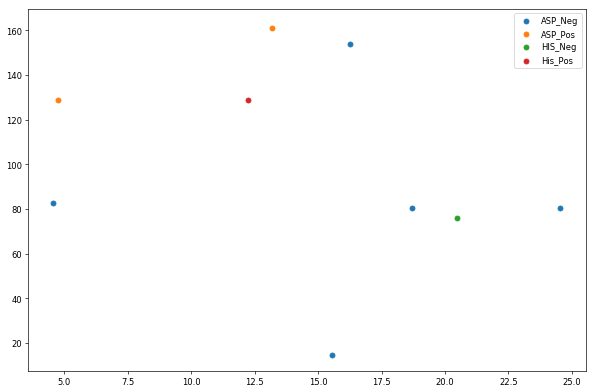

In [160]:
plt.figure(figsize = (12,8),dpi=60)

plt.scatter(distanceMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.scatter(distanceMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[190,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])
plt.xlabel("Distance")
plt.ylabel("Angle")

plt.show()

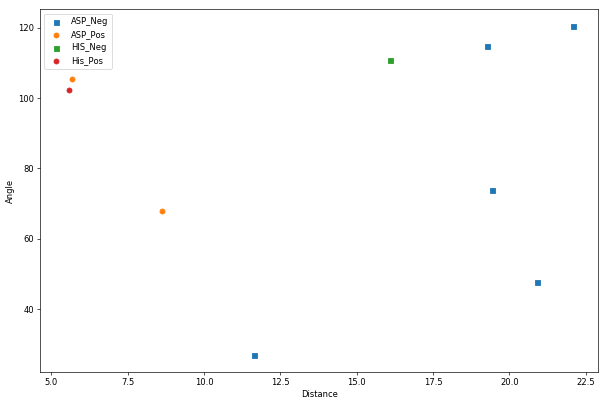

In [167]:
plt.figure(figsize = (12,8),dpi=60)

plt.scatter(distanceMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.scatter(distanceMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[195,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")

plt.show()